Assignment 4: 

Name: **ASHUTOSH REDDY ATIMYALA**

UID: **118442129**

Course: CMSC733

Please submit to ELMS
- a PDF containing all outputs (by executing **Run all**)
- your ipynb notebook containing all the code

I understand the policy on academic integraty (collaboration and the use of online material).
Please sign your name here: **ASHUTOSH REDDY ATIMYALA**

In [1]:
## Import necessary libraries here (You can add libraries you want to use here)
from skimage.util import img_as_float
from skimage import io, color
from skimage import draw
import matplotlib.pyplot as plt
import argparse, time
import math, copy
import numpy as np
import scipy.io
import cv2
from PIL import Image, ImageDraw
import itertools
import os
import timeit
from statistics import mean
from sklearn.mixture import GaussianMixture
from google.colab.patches import cv2_imshow

In [2]:
def show_image(img, scale=3.0):
    plt.figure(figsize=scale* plt.figaspect(1))
    plt.imshow(img, interpolation='nearest')
    plt.gray() 
    plt.axis('off')
    plt.show()

# Part 1: SLIC Superpixels (50 Points)

## Overview

Superpixel algorithms group pixels into perceptually meaningful regions while respecting potential object contours, and thereby can replace the rigid pixel grid structure. Due to the reduced complexity, superpixels are becoming popular for various computer vision applications, e.g., multiclass object segmentation, depth estimation, human pose estimation, and object localization.

In this problem, you will implement a simple superpixel algorithm called Simple Linear Iterative Clustering (SLIC) that clusters pixels in the five-dimensional color and pixel coordinate space (e.g., r, g, b, x, y). The algorithm starts with a collection of K cluster centers initialized at an equally sampled regular grid on the image of N pixels. For each cluster, you define for a localized window 2S x 2S centered at the cluster center, where S = sqrt(N/K) is the roughly the space between the seed cluster centers. Then, you check whether the pixel within the 2S x 2S local window should be assigned to the cluster center or not (by comparing the distance in 5D space to the cluster center). Once you loop through all the clusters, you can update the cluster center by averaging over the cluster members. Iterate the pixel-to-cluster assignment process till convergence or maximum iterations reached.

Reference Paper: http://www.kev-smith.com/papers/SMITH_TPAMI12.pdf

You can refer to the following slide covered in Lecture_17_Segmentation.pptx here: https://drive.google.com/file/d/1bRmNBXgK1_kWcY-nhw_As5fP10aRhuDC/view?usp=share_link






## Data
**WARNING: Colab deletes all files everytime runtime is disconnected. Make sure to re-download the inputs when it happens.**

In [ ]:
# Download Data -- run this cell only one time per runtime
!gdown 1jbg2VMZ9yAJMHQNRCTgqZM1PyQRtcPyV
!unzip "/content/Part1_SLIC.zip" -d "/content/"

## Helper Functions:

### Code (15 pts)

In [4]:
# A class to initialize the super pixels, of the form - [l,a,b,h,w].
class SuperPixel(object):

    def __init__(self, l=0, a=0, b=0, h=0, w=0):
        self.update(l, a, b, h, w)
        self.pixels = []

    def update(self, l, a, b, h, w):
        self.l = l
        self.a = a
        self.b = b
        self.h = h
        self.w = w

# Function which returns an object of class SuperPixel
def make_SuperPixel(h, w,img):
    return SuperPixel(img[h,w][0],img[h,w][1],img[h,w][2], h, w)

def drawBorders(image):
    """
    Helper function to draw borders around pixels of differentiating intensity, indicating the pixel is a border
    :param image: The superpixeled image as a 2D numpy array
    :return: The image with borders drawn
    """
    for i in range(image.shape[0]):
        for j in range(1, image.shape[1] - 1):
            pixel = image[i, j, :]
            previousPixel = image[i, j - 1, :]
            nextPixel = image[i, j + 1, :]

            if (not np.array_equal(pixel, previousPixel)) and (np.array_equal(pixel, nextPixel)):
                image[i, j - 1][0] = 255
                image[i, j - 1][1] = 255
                image[i, j - 1][2] = 255

    for j in range(image.shape[1]):
        for i in range(1, image.shape[0] - 1):
            pixel = image[i, j, :]
            previousPixel = image[i - 1, j, :]
            nextPixel = image[i + 1, j, :]

            if (not np.array_equal(pixel, previousPixel)) and (np.array_equal(pixel, nextPixel)):
                image[i, j - 1][0] = 255
                image[i, j - 1][1] = 255
                image[i, j - 1][2] = 255
    return image

def display_clusters(img, clusters,mark_borders=False):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        image[c.h, c.w][0] = 0
        image[c.h, c.w][1] = 0
        image[c.h, c.w][2] = 0
    rgb_arr = color.lab2rgb(image) 
    if mark_borders:
       rgb_arr = drawBorders(rgb_arr)
    show_image(rgb_arr)


In [5]:
# Functions for Simple Linear Iterative Clustering (SLIC)
def initialize_cluster_centers(S, image, img_h, img_w, clusters):
    #### Write your code here ####
    # To Do: Initialize "clusters" by sampling pixels at an equally sampled regular grid (distanced by S)
    # on the image of N pixels. N = img_h X img_w. Hint: clusters.append(make_superPixel(h, w, image)) to create each cluster/super-pixel.
    for h,w in itertools.product(range(int(S/2),img_h,S),range(int(S/2),img_w,S)):
      clusters.append(make_SuperPixel(h,w,image))
    return clusters

def gradientPixel(h, w,image):
    w = image.shape[1] - 2 if w + 1 >= image.shape[1] else w
    h = image.shape[0] - 2 if h + 1 >= image.shape[0] else h    
           
    gradientx = math.sqrt((image[h,w+1][0] - image[h,w-1][0])**2 + (image[h,w+1][1] - image[h,w-1][1])**2 + (image[h,w+1][2] - image[h,w-1][2])**2)
    gradienty = math.sqrt((image[h+1,w][0] - image[h-1,w][0])**2 + (image[h+1,w][1] - image[h-1,w][1])**2 + (image[h+1,w][2] - image[h-1,w][2])**2)
    return gradientx + gradienty

def relocate_cluster_center_at_lowgrad(clusters, image):
    #### Write your code here ####
    # To Do:
    # for each cluster c, reassign cluster to the pixel having smallest gradient value.
    # Step 1: compute gradient wrt cluster-center c.h, c.w in 3X3 neighborhood of cluster center.
    # Step 2: Similarly, compute gradient for each pixel in 3X3 spatial neighborhood of cluster c.
    # Step 3. Reassign cluster-center to the pixel (x,y) having the lowest gradient. 
    # Hint: c.update(img[x,y][0], img[h,w][1], img[x,y][2], x, y)
    for c in clusters:
      gradient = gradientPixel(c.h,c.w,image)
      for h,w in itertools.product(range(-1, 2),range(-1, 2)):
          x = c.h + h
          y = c.w + w
          new_gradient = gradientPixel(x, y,image)
          if new_gradient < gradient:
              c.update(image[x,y][0], image[x,y][1], image[x,y][2],x,y)
              gradient = new_gradient
    return None

def assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis,M):
    #### Write your code here ####
    # To Do: Compare each pixel to cluster center within 2S pixel distance and assign to nearest cluster using the "distance metric"
    # (involving both color and spatial dimensions of pixel and cluster, 
    # Hints: 
    # 1. use "dis" matrix for comparing distances.
    # 2. You can use c.pixels.append((h, w)) to keep track of cluster-assignments.
    for c in clusters:
      for h,w in itertools.product(range(c.h - 2 * S, c.h + 2 * S),range(c.w - 2 * S, c.w + 2 * S)):
        if h < 0 or h >= img_h: continue  
        if w < 0 or w >= img_w: continue
        d_lab = math.sqrt((image[h,w][0] - c.l)**2 + (image[h,w][1] - c.a)**2 + (image[h,w][2] - c.b)**2)
        d_xy = math.sqrt((h - c.h)**2 + (w - c.w)**2)
        Dist_sum = math.sqrt((d_lab)**2 + ((M/S) *d_xy)**2)  #sum of lab distance and xy plane distance normalized by the grid interval S
        # Dist_sum = math.sqrt((d_lab / M)**2 + (d_xy /S)**2)
        if Dist_sum < dis[h,w]:
          dis[h, w] = Dist_sum
          if (h, w) not in cluster_tag:
              cluster_tag[(h, w)] = c
              c.pixels.append((h, w))
          else:
              cluster_tag[(h, w)].pixels.remove((h, w))
              cluster_tag[(h, w)] = c
              c.pixels.append((h, w))
    return None

def update_clusters(clusters,image):
    #### Write your code here ####
    # To Do: For each cluster, update the cluster center with mean of the pixels assigned (c.pixels)
    # for cluster in clusters:
    for c in clusters:
      sum_h,sum_w = 0,0
      for pixel in c.pixels:
        sum_h += pixel[0]
        sum_w += pixel[1]
      mean_h = int(sum_h / len(c.pixels))
      mean_w = int(sum_w / len(c.pixels))
      c.update(image[mean_h, mean_w][0],image[mean_h, mean_w][1],image[mean_h, mean_w][2], mean_h, mean_w)
    return None

def compute_res_error(old_clusters, new_clusters):
    #### Write your code here ####
    error = 0.0
    # error = Compute L1 distance between previous cluster-centres and new cluster centers.
    for new_c,old_c in zip(new_clusters,old_clusters):
        error_lab = abs(new_c.l - old_c.l) + abs(new_c.a - old_c.a) + abs(new_c.b - old_c.b)
        error_hw = abs(new_c.h - old_c.h) + abs(new_c.w - old_c.w)
        error += (error_lab + error_hw)
    return error

def slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M,verbose=False):

    # Initialize cluster centers on pixel grid in steps S
    clusters = initialize_cluster_centers(S, image, img_h, img_w, clusters)

    # Move centers to position in 3x3 window with smallest gradient.
    relocate_cluster_center_at_lowgrad(clusters, image)

    # You can play around with these hyper-params.
    res_err = 123456789.0 # init residual_error with a very large value (choose as per your understanding.)
    threshold = 0.01 # tune this

    i=0
    init_error = res_err
    while(res_err >= threshold):

      assign_cluster(clusters, S, image, img_h, img_w, cluster_tag, dis,M)
      old_clusters = copy.deepcopy(clusters)
      update_clusters(clusters,image)

      res_err = compute_res_error(old_clusters, clusters)
      init_error = res_err if i==0 else init_error
      i+=1
      if res_err<threshold:
        if verbose: print("Error at initialization: ",init_error,'\n',"Error at Convergence: ",res_err)
        break
    
    return clusters    


SLIC Run Time at k = 64 :  107.71877375199983 seconds


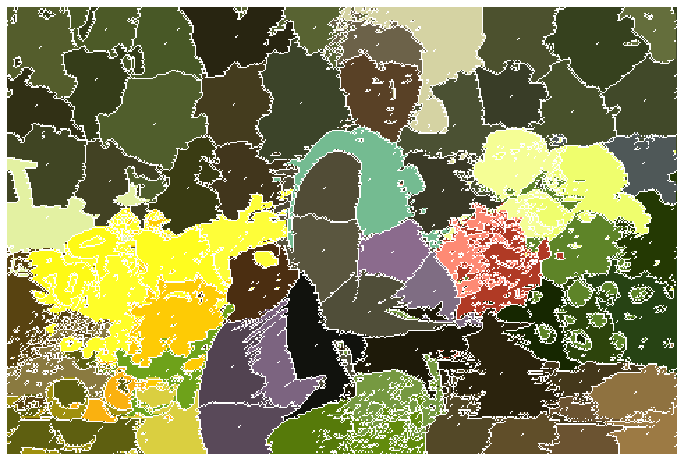

In [30]:
# Main Block:
img_path = "/content/Part1_SLIC/BSD_data/images/16004.jpg"

# Load image and convert it from an unsigned 8-bit integer to a floating point data type.
image = img_as_float(io.imread(img_path))
# convert RGB to LAB
image = color.rgb2lab(image)
img_h = image.shape[0] #  Height
img_w = image.shape[1] #  Width

# k: Number of clusters/superpixels.
k = 64
N = img_h * img_w  # Total pixels in the image
S = int(math.sqrt(N /k)) # Average size of each superpixel

clusters = []
cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.
start = timeit.default_timer()

clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M=20)
stop = timeit.default_timer()
print('SLIC Run Time at k =', +k ,': ', stop - start,"seconds")  
display_clusters(image, clusters,mark_borders=True)

**B. Choose one image, try three different weights on the color and spatial feature and show the three segmentation results. Describe what you observe.  
C. Choose one image, show the error (1) at the initialization and (2) at convergence. Note: error - distance to cluster center in the 5D space** 


Weight M=  2 :
Error at initialization:  23239.596308908604 
 Error at Convergence:  0.0


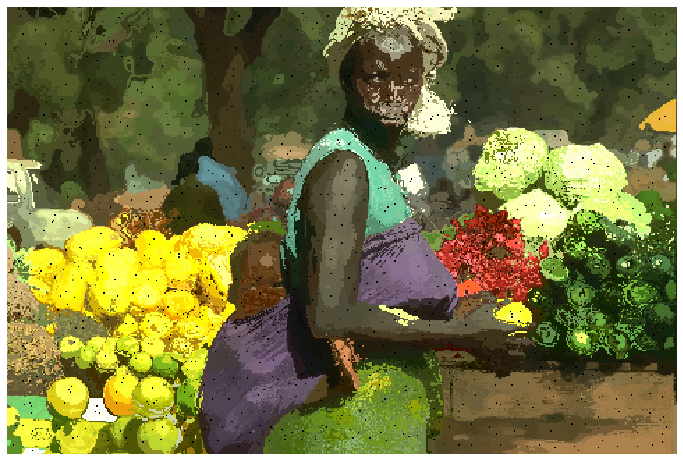


Weight M=  10 :
Error at initialization:  15343.859905207675 
 Error at Convergence:  0.0


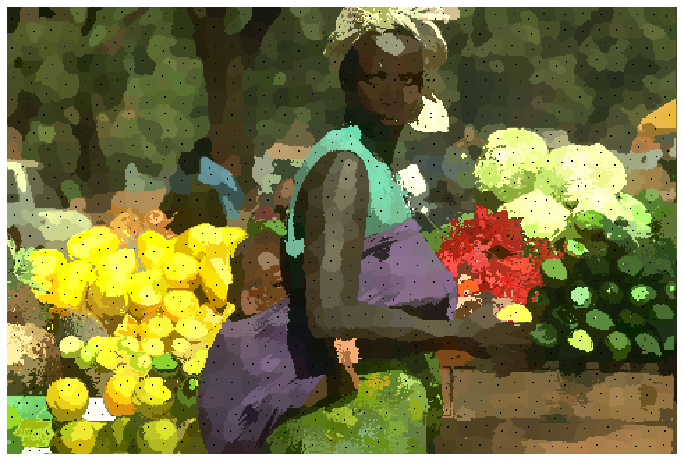


Weight M=  20 :
Error at initialization:  11675.292847080178 
 Error at Convergence:  0.0


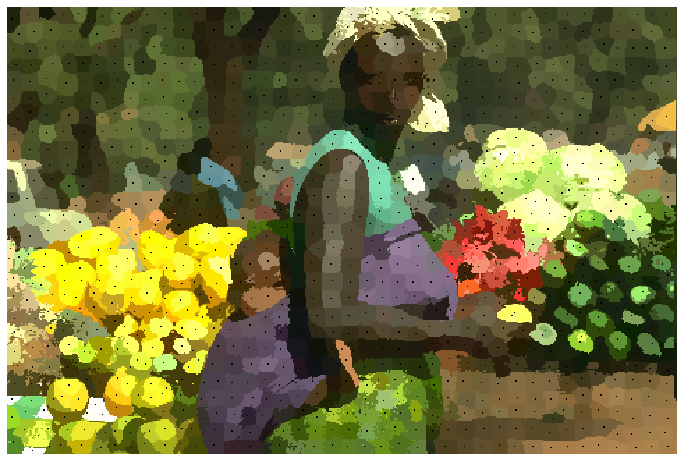

In [7]:
for M in (2,10,20):
  img_path = "/content/Part1_SLIC/BSD_data/images/16004.jpg" #2,10,20
  # Load image and convert it from an unsigned 8-bit integer to a floating point data type.
  image = img_as_float(io.imread(img_path))
  # convert RGB to LAB
  image = color.rgb2lab(image)
  img_h = image.shape[0] #  Height
  img_w = image.shape[1] #  Width

  # k: Number of clusters/superpixels.
  k = 1024
  N = img_h * img_w  # Total pixels in the image
  S = int(math.sqrt(N /k)) # Average size of each superpixel

  clusters = []
  cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
  dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.

  print("\nWeight M= ",M,":")
  clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M,verbose=True)
  display_clusters(image, clusters,mark_borders=False)

**D. Choose one image and show three superpixel results with different number of K, e.g., 64, 256, 1024 and run time for each K.**


SLIC Run Time at k = 64 :  172.781948726 seconds


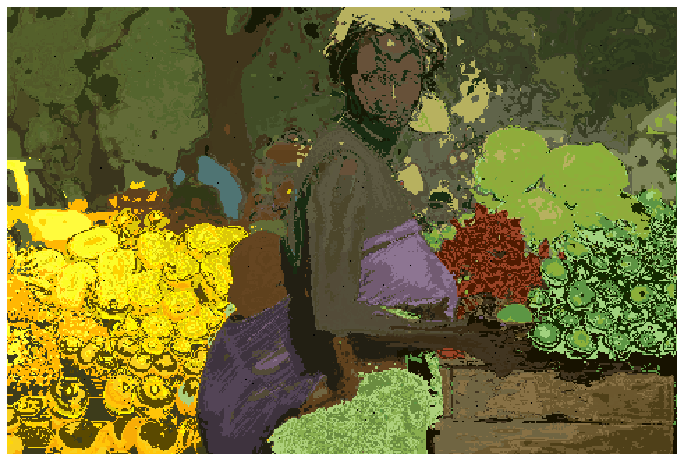


SLIC Run Time at k = 256 :  204.3860600789999 seconds


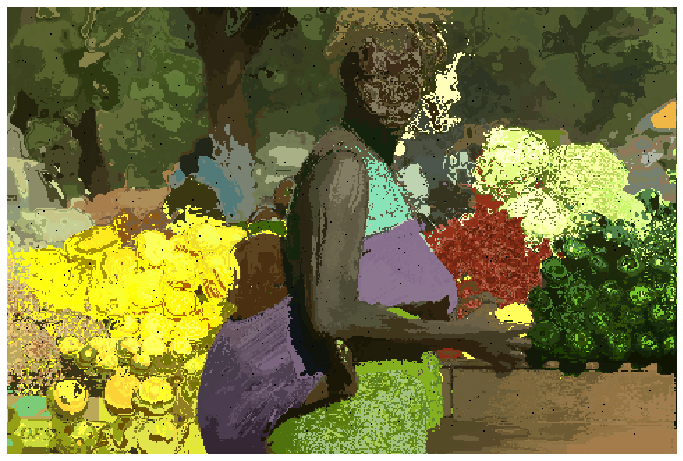


SLIC Run Time at k = 1024 :  164.65089124999997 seconds


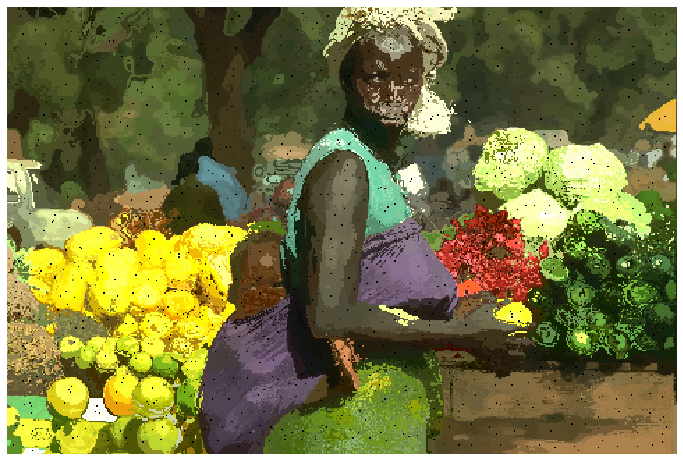

In [8]:
for k in (64,256,1024):
  img_path = "/content/Part1_SLIC/BSD_data/images/16004.jpg"

  # Load image and convert it from an unsigned 8-bit integer to a floating point data type.
  image = img_as_float(io.imread(img_path))
  # convert RGB to LAB
  image = color.rgb2lab(image)
  img_h = image.shape[0] #  Height
  img_w = image.shape[1] #  Width

  # k: Number of clusters/superpixels.
  N = img_h * img_w  # Total pixels in the image
  S = int(math.sqrt(N /k)) # Average size of each superpixel

  clusters = []
  cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
  dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.

  #start time
  start = timeit.default_timer()
  clusters1 = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M=2)
  #stop time
  stop = timeit.default_timer()
  print('\nSLIC Run Time at k =', +k ,': ', stop - start,"seconds")  

  display_clusters(image, clusters1,mark_borders=False)

**E. Run your algorithms on the subset (50 images) of Berkeley Segmentation Dataset (BSD) with K = 64, 256 and 1024 and report averaged run-time per image for the BSD.**

In [9]:
images_list = os.listdir("/content/Part1_SLIC/BSD_data/images")
for im in images_list[:10]:
  run_time_list = []
  for k in (64,256,1024):
    img_path = "/content/Part1_SLIC/BSD_data/images/" + im

    # Load image and convert it from an unsigned 8-bit integer to a floating point data type.
    image = img_as_float(io.imread(img_path))
    # convert RGB to LAB
    image = color.rgb2lab(image)
    img_h = image.shape[0] #  Height
    img_w = image.shape[1] #  Width

    # k: Number of clusters/superpixels.
    N = img_h * img_w  # Total pixels in the image
    S = int(math.sqrt(N /k)) # Average size of each superpixel

    clusters = []
    cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
    dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.
    start = timeit.default_timer()
    clusters1 = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M=15)
    stop = timeit.default_timer()
    run_time = stop - start
    print("Run time of ",im,"for K=",k,":",run_time,"seconds")
    run_time_list.append(run_time)
  avg_runtime = mean(run_time_list)
  print("Averaged Run-time of image(",im,")for k=64,256,1024 :",avg_runtime,"seconds\n")

Run time of  49024.jpg for K= 64 : 120.35878836899997 seconds
Run time of  49024.jpg for K= 256 : 64.00820514300017 seconds
Run time of  49024.jpg for K= 1024 : 97.02570117899995 seconds
Averaged Run-time of image( 49024.jpg )for k=64,256,1024 : 93.79756489700003 seconds

Run time of  14085.jpg for K= 64 : 169.97756460899996 seconds
Run time of  14085.jpg for K= 256 : 103.92945089299997 seconds
Run time of  14085.jpg for K= 1024 : 76.13413700000001 seconds
Averaged Run-time of image( 14085.jpg )for k=64,256,1024 : 116.68038416733332 seconds

Run time of  69022.jpg for K= 64 : 135.5241637270001 seconds
Run time of  69022.jpg for K= 256 : 94.44482716900006 seconds
Run time of  69022.jpg for K= 1024 : 107.91613578800025 seconds
Averaged Run-time of image( 69022.jpg )for k=64,256,1024 : 112.62837556133347 seconds

Run time of  69000.jpg for K= 64 : 128.584893835 seconds
Run time of  69000.jpg for K= 256 : 69.95679191299996 seconds
Run time of  69000.jpg for K= 1024 : 106.27006895499972 sec

### Write-up (35 pts)
* a) [5 points] Explain your distance function for measuring the similarity between a pixel and cluster in the 5D space.
* b) [5 points] Choose one image, try three different weights on the color and spatial feature and show the three segmentation results. Describe what you observe.
* c) [5 points] Choose one image, show the error (1) at the initialization and (2) at convergence. Note: error - distance to cluster center in the 5D space.
* d) [10 points] Choose one image and show three superpixel results with different number of K, e.g., 64, 256, 1024 and run time for each K.
* e)  [10 points] Run your algorithms on the subset (50 images) of Berkeley Segmentation Dataset (BSD) with K = 64, 256 and 1024 and report averaged run-time per image for the BSD.


##Write-up: 
###A.
**If spatial distances exceed the perceptual color distance limit(Euclidean distances in CIELAB color space), they result in superpixels that disregard region boundaries. Therefore, Distance measure is defined as:  
d<sub>lab</sub> = ((l<sub>k</sub> - l<sub>i</sub>)<sup>2</sup> + (a<sub>k</sub> - a<sub>i</sub>)<sup>2</sup> + (b<sub>k</sub> - b<sub>i</sub>)<sup>2</sup>)<sup>1/2</sup>  
d<sub>xy</sub> = ((x<sub>k</sub> - x<sub>i</sub>)<sup>2</sup> + (y<sub>k</sub> - y<sub>i</sub>)<sup>2</sup>)<sup>1/2</sup>  
D<sub>s</sub> = ((d<sub>lab</sub>)<sup>2</sup> + ((m/S) d<sub>xy</sub>)<sup>2</sup>)<sup>1/2</sup>  
D<sub>s</sub> is the sum of lab distance and the xy plane distance normalized by the grid interval S. Where 'm' ranging between [1,40] is used to control the compactness of a superpixel,i.e, higher value of m describes the higher compactness of the cluster with more spatial proximity.**  

###B.
**From the provided results, it can be inferred that as the value of M(weight on the color and spatial feature) increases (in this case: 2,10,20) the cluster becomes more compact by giving more emphasis on the spatial distances, i.e., the spatial distances donot exceed the euclidean distance in color space.**

### Extra Credit (20 pts)
* f) [upto 10 points] Implement and report two types of metrics (1) boundary recall and (2) under-segmentation error with K = 64, 256 and 1024 on the BSD (last part of write-up).
* g) [upto 10 points] Try to improve your result from first part of extra-credit. You may try different color space (e.g., CIELab, HSV) (See Sec 4.5 in the paper), richer image features (e.g., gradients) or any other ideas you come up with. Report the accuracy on boundary recall and under-segmentation error with K = 256. Compare the results with first-part of extra-credit and explain why you get better results.

###F.
**Implement and report two types of metrics (1) boundary recall and (2) under-segmentation error with K = 64, 256 and 1024 on the BSD (last part of write-up).**

In [15]:
def UnderSegmentationError(S, clusters, gt_segmentation, img_h, img_w,N):
    gt_segments = []
    for h in range(img_h):
        for w in range(img_w):
            if gt_segmentation[h,w] not in gt_segments:
                gt_segments.append(gt_segmentation[h,w])
    superpixel_output = []
    for c in clusters:
        superpixel_output.append(c.pixels)
    B = 0.05
    under_segmentation_error = 0
    for i, superpixel in enumerate(superpixel_output):
        for gt_segment in gt_segments:
            intersection = 0
            for p in superpixel:
                if gt_segmentation[p[0],p[1]] == gt_segment:
                    intersection += 1
            if intersection / len(superpixel) > B:
                under_segmentation_error += len(superpixel)
    under_segmentation_error = 1/len(gt_segments) * (under_segmentation_error - N)
    under_segmentation_error = under_segmentation_error / len(gt_segments)
    return under_segmentation_error

def boundaryRecall(clusters, ground_truth, img_h, img_w):
    boundary_recall = 0.0
    cluster_boundary = []
    for c in clusters:
        boundary = []
        for pixel in c.pixels:
            if (pixel[0]-1,pixel[1]) not in c.pixels or (pixel[0]+1,pixel[1]) not in c.pixels or (pixel[0],pixel[1]-1) not in c.pixels or (pixel[0],pixel[1]+1) not in c.pixels:
                boundary.append(pixel)
        cluster_boundary.append(boundary)
    intersection = 0
    for boundary in cluster_boundary:
        for pixel in boundary:
            if ground_truth[pixel[0],pixel[1]] == 1:
                intersection += 1
    boundary_recall = intersection / np.sum(ground_truth)
    return boundary_recall

for k in (64,256,1024):
  img_path = "/content/Part1_SLIC/BSD_data/images/16004.jpg"

  # Load image and convert it from an unsigned 8-bit integer to a floating point data type.
  image = img_as_float(io.imread(img_path))
  # convert RGB to LAB
  image = color.rgb2lab(image)
  img_h = image.shape[0] #  Height
  img_w = image.shape[1] #  Width

  ground_truth = scipy.io.loadmat('/content/Part1_SLIC/BSD_data/groundTruth/test/16004.mat')['groundTruth']
  gt_ = ground_truth[0]
  gt_ = gt_[0]
  gt_boundary = gt_['Boundaries'][0][0]
  gt_segmentation = gt_['Segmentation'][0][0]

  img_h_ = gt_boundary.shape[0] #  Height
  img_w_ = gt_boundary.shape[1] #  Width

  gt_boundary = np.array(gt_boundary)
  gt_boundary = gt_boundary.astype(np.uint8)
  gt_boundary = cv2.resize(gt_boundary, (img_w_, img_h_), interpolation = cv2.INTER_AREA)

  gt_segmentation = np.array(gt_segmentation)
  gt_segmentation = gt_segmentation.astype(np.uint8)
  gt_segmentation = cv2.resize(gt_segmentation, (img_w_, img_h_), interpolation = cv2.INTER_AREA)

  # k: Number of clusters/superpixels.
  N = img_h * img_w  # Total pixels in the image
  S = int(math.sqrt(N /k)) # Average size of each superpixel

  clusters = []
  cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
  dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.

  clusters1 = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis,M=20)
  boundary_recall=boundaryRecall(clusters1, gt_boundary, img_h, img_w)
  under_segmentation_error=UnderSegmentationError(S, clusters1, gt_segmentation, img_h, img_w,N)
  
  print(f'\nBoundary Recall for K= {k} is  :  {boundary_recall}')
  print(f'Undersegmentation Error for K= {k} is  :   {under_segmentation_error}')


Boundary Recall for K= 64 is  :  0.4749397590361446
Undersegmentation Error for K= 64 is  :   60.25378071833648

Boundary Recall for K= 256 is  :  0.5207228915662651
Undersegmentation Error for K= 256 is  :   33.16257088846881

Boundary Recall for K= 1024 is  :  0.584578313253012
Undersegmentation Error for K= 1024 is  :   16.7679584120983


###G. 
**Try to improve your result from first part of extra-credit. You may try different color space (e.g., CIELab, HSV) (See Sec 4.5 in the paper), richer image features (e.g., gradients) or any other ideas you come up with. Report the accuracy on boundary recall and under-segmentation error with K = 256. Compare the results with first-part of extra-credit and explain why you get better results.**

Runtime: 136.06158803200015 seconds

Boundary Recall for HSV color space when K= 256 is  :  0.584578313253012
Undersegmentation Error HSV color space when for K= 256 is  :   16.7679584120983


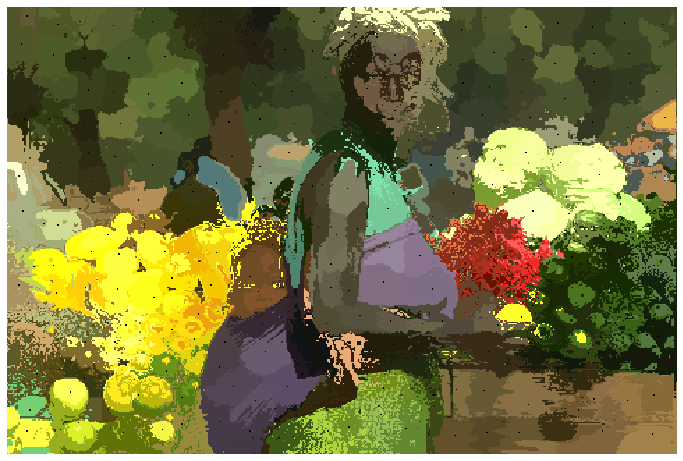

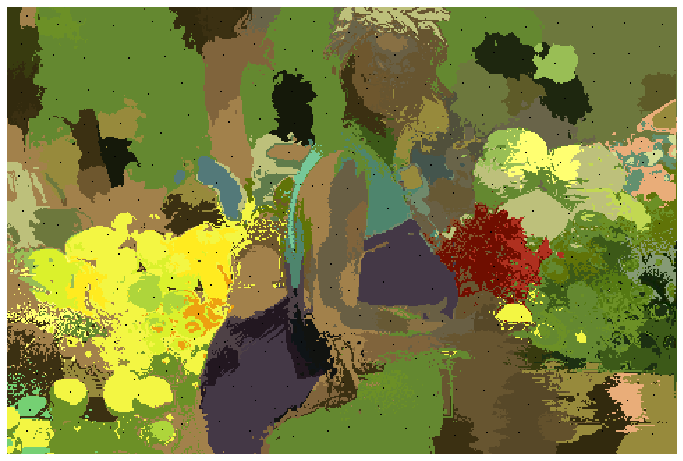

In [16]:
def display_clusters_hsv(img, clusters):
    image = np.copy(img)
    for c in clusters:
        for p in c.pixels:
            image[p[0],p[1]][0] = c.l
            image[p[0],p[1]][1] = c.a
            image[p[0],p[1]][2] = c.b
        image[c.h, c.w][0] = 0
        image[c.h, c.w][1] = 0
        image[c.h, c.w][2] = 0
    rgb_arr = color.hsv2rgb(image) 
    show_image(rgb_arr)
    return rgb_arr

def combineClusters(clusters):
    clusters_combined = []
    for c in clusters:
        c_h = c.l
        c_s = c.a
        c_v = c.b
        c_H = c.h
        c_W = c.w
        for c2 in clusters:
            thresh = 0.2
            c2_H = c2.h
            c2_W = c2.w
            if math.sqrt((c_H - c2_H)**2 + (c_W + c2_W)**2) < 30*S:
                if abs(c2.l-c_h) < thresh/5 and abs(c2.a-c_s) < thresh and abs(c2.b-c_v) < thresh*2:
                    obj_out = copy.deepcopy(c2)
                    obj_out.l = c_h
                    obj_out.a = c_s
                    obj_out.b = c_v    
                    clusters_combined.append(obj_out)
    return clusters_combined
    

img_path = "/content/Part1_SLIC/BSD_data/images/16004.jpg"
image = img_as_float(io.imread(img_path))

# convert RGB to HSV
image = color.rgb2hsv(image)
img_h = image.shape[0] #  Height
img_w = image.shape[1] #  Width

# k: Number of clusters/superpixels.
k = 256
N = img_h * img_w  # Total pixels in the image
S = int(math.sqrt(N /k)) # Average size of each superpixel
M = 0.1

clusters = []
cluster_tag = {} # cluster_tag should contain cluster-assignment for pixel h,w. For example, cluster_tag[(h, w)] = c
dis = np.full((img_h, img_w), np.inf) # Distance bwteen pixels and cluster is initialized as infinity at the beginning.

ground_truth = scipy.io.loadmat('/content/Part1_SLIC/BSD_data/groundTruth/test/16004.mat')['groundTruth']
gt_ = ground_truth[0]
gt_ = gt_[0]
gt_boundary = gt_['Boundaries'][0][0]
gt_segmentation = gt_['Segmentation'][0][0]

img_h_ = gt_boundary.shape[0] #  Height
img_w_ = gt_boundary.shape[1] #  Width

gt_boundary = np.array(gt_boundary)
gt_boundary = gt_boundary.astype(np.uint8)
gt_boundary = cv2.resize(gt_boundary, (img_w_, img_h_), interpolation = cv2.INTER_AREA)

gt_segmentation = np.array(gt_segmentation)
gt_segmentation = gt_segmentation.astype(np.uint8)
gt_segmentation = cv2.resize(gt_segmentation, (img_w_, img_h_), interpolation = cv2.INTER_AREA)
start = timeit.default_timer()
clusters = slic_algorithm(S, image, img_h, img_w, clusters, cluster_tag, dis, M)
stop = timeit.default_timer()
run_time = stop - start
print('Runtime:',run_time,'seconds')
boundary_recall=boundaryRecall(clusters1, gt_boundary, img_h, img_w)
under_segmentation_error=UnderSegmentationError(S, clusters1, gt_segmentation, img_h, img_w,N)

print(f'\nBoundary Recall for HSV color space when K= {k} is  :  {boundary_recall}')
print(f'Undersegmentation Error HSV color space when for K= {k} is  :   {under_segmentation_error}')

seg_img = display_clusters_hsv(image, clusters)

# Reduce Over-Segmentation
clusters_combined = combineClusters(clusters)
seg_img_less = display_clusters_hsv(image, clusters_combined)

###Write-up
###G.
**The ouput obtained from the slic with CIELAB color space provided an over segmented image. So, for reducing the over-segmentation HSV colorspace is used for slic and further the over segmented clusters are combined together based on the resemblance of their hsv values. It can also be seen that the runtime is reduced when using hsv colorspace. The results show that the undersegmentation error when compared to the previous question is reduced.**

### Hints 
- For main part, you CAN NOT use any library such as skimage / cv2 to perform or implement SLIC segmentation.
- For better visualization, you may use external function (skimage.segmentation.mark_boundaries) for your purpose.
- For EXTRA CREDIT part, you are allowed to use external library for metrics (boundary recall and under-segmentation error)

# Part 2: Graph-cut Segmentation (50 points)

## Overview

Let us apply Graph-cuts for foreground/background segmentation. In the “cat” image, you are given a rough polygon of a foreground cat. Apply graph-cut based method to see if we can get a better segmentation!

Firstly, use the provided polygon to obtain an estimate of foreground and background color likelihood. You may choose the likelihood distribution (e.g., color histograms or color mixture of Gaussians.).

Secondly, apply graph-cut code (cv2.grabcut) to do better segmentation. You can use the provided bounding-boxes and use "cv2 package" for the implementation sake. You are required to draw interesting conclusions on how it performs on different samples.

## Data 

In [10]:
# Download Data -- run this cell only one time per runtime
# !gdown 1ObpNoshjKMcB7SFvrTuoKe61IE-HG95n
!gdown 1Tw_gk0yylwl2X1leubz0mlERpxsqLiub
!unzip "/content/Part2_GraphCut.zip" -d "/content/"

Downloading...
From: https://drive.google.com/uc?id=1Tw_gk0yylwl2X1leubz0mlERpxsqLiub
To: /content/Part2_GraphCut.zip
100% 264k/264k [00:00<00:00, 130MB/s]
Archive:  /content/Part2_GraphCut.zip
   creating: /content/Part2_GraphCut/
  inflating: /content/Part2_GraphCut/dog.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._dog.jpg  
  inflating: /content/Part2_GraphCut/messi.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._messi.jpg  
  inflating: /content/Part2_GraphCut/.DS_Store  
  inflating: /content/__MACOSX/Part2_GraphCut/._.DS_Store  
  inflating: /content/Part2_GraphCut/plane.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._plane.jpg  
  inflating: /content/Part2_GraphCut/bird.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._bird.jpg  
  inflating: /content/Part2_GraphCut/cat.jpg  
  inflating: /content/__MACOSX/Part2_GraphCut/._cat.jpg  
  inflating: /content/Part2_GraphCut/cat_poly.mat  
  inflating: /content/__MACOSX/Part2_GraphCut/._cat_poly.mat  


## Helper Functions

#### Code (15 pts)

In [11]:
def poly2mask(vertex_row_coords, vertex_col_coords, shape):
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

# Get a normalized version of the given histograms (divide by sum)
def normalize_histograms(histograms):
  return np.float32([h / h.sum() for h in histograms])


In [12]:
def mask_for_fg(img, img_mask):
  # Write code here 
  # to generate foreground region (and everything else masked out).
  fg_image = np.zeros(img.shape)
  fg_image[img_mask] = img[img_mask]
  return fg_image

def mask_for_bg(img, img_mask):
  # Write code here
  # generate background region (and everything else masked out).
  bg_image = np.zeros(img.shape)
  bg_image[~img_mask] = img[~img_mask]
  return bg_image


def visualize_likelihood_map(gmm_bg, gmm_fg, img):
  # Write your code here.
  gmm_bg_likelihood_map = gmm_bg.score_samples(img.reshape(-1, 3))
  gmm_fg_likelihood_map = gmm_fg.score_samples(img.reshape(-1, 3))
  
  gmm_fg_likelihood_map = gmm_fg_likelihood_map.reshape(img.shape[:2])
  gmm_bg_likelihood_map = gmm_bg_likelihood_map.reshape(img.shape[:2])

  return gmm_bg_likelihood_map,gmm_fg_likelihood_map

def gaussian_model(img):
  # Write your code here.
  # fit gaussian model on a given image.
  gmm_model, gmm_labels = None, None
  img2 = img.reshape((-1,3))
  gmm_model = GaussianMixture(n_components=2, covariance_type='full').fit(img2)
  gmm_labels = gmm_model.predict(img2)
  segmented_image = gmm_labels.reshape(img.shape[0],img.shape[1])
  segmented_image = segmented_image * 255
  cv2_imshow(segmented_image)
  return gmm_model, gmm_labels

def run_grabcut(img, bbox,iterCount):
  # Write your code here.
  # You can use opencv cv2.grabCut algorithm with "cv2.GC_INIT_WITH_RECT" to implement this.
  grabcut_mask = np.zeros(img.shape[:2],np.uint8)
  bgModel, fgModel = None, None
  grabcut_mask, bgModel, fgModel = cv2.grabCut(img,grabcut_mask,bbox,bgModel,fgModel,iterCount,cv2.GC_INIT_WITH_RECT)
  grabcut_mask =  np.where((grabcut_mask == 2)|(grabcut_mask == 0), 0, 1).astype('uint8')
  return (grabcut_mask, bgModel, fgModel)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


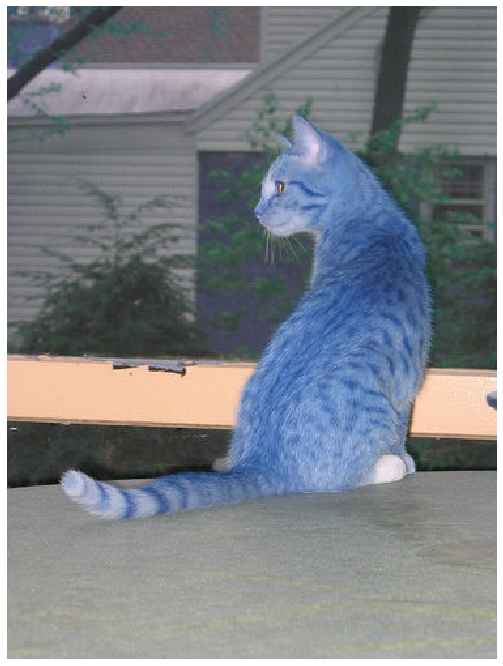

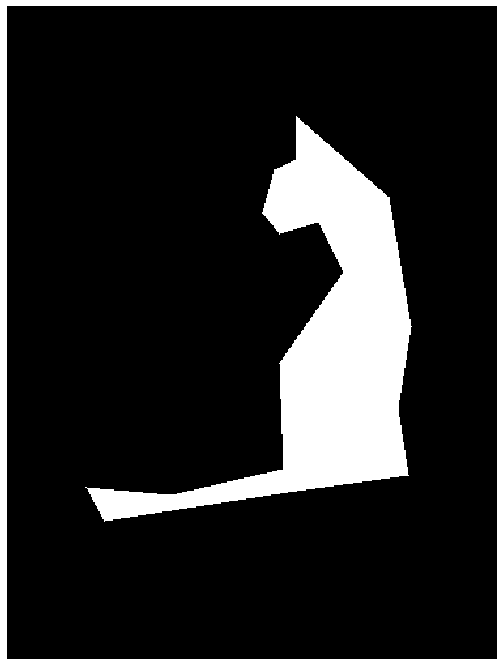

In [13]:
### Main Block: ###

# read image
img_name = 'cat'
img_path = '/content/Part2_GraphCut/cat.jpg'
img = cv2.imread(img_path)

# read image_mask
poly = scipy.io.loadmat('/content/Part2_GraphCut/cat_poly.mat')['poly']
img_mask = poly2mask(poly[:,1], poly[:,0], (img.shape[0],img.shape[1]))

show_image(img)
show_image(img_mask)

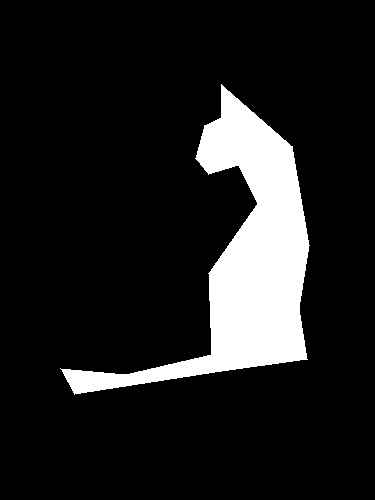

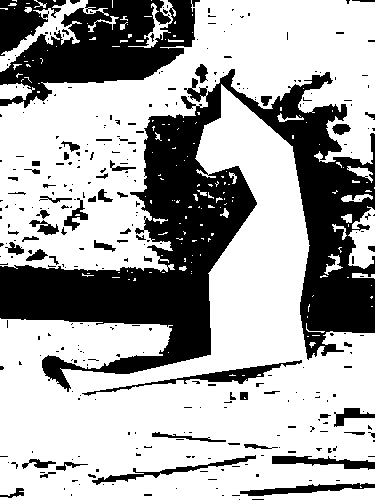

In [14]:
# 1. Fit Gaussian mixture model for foreground regions.

# Generate image (fg_image) with background masked using img_mask
fg_image = mask_for_fg(img, img_mask)
gmm_fg, fg_gmm_labels = gaussian_model(fg_image)


# 2. Fit Gaussian mixture model for background regions.
# Generate image (fg_image) with foreground masked using img_mask
bg_image = mask_for_bg(img, img_mask)
gmm_bg, bg_gmm_labels = gaussian_model(bg_image)

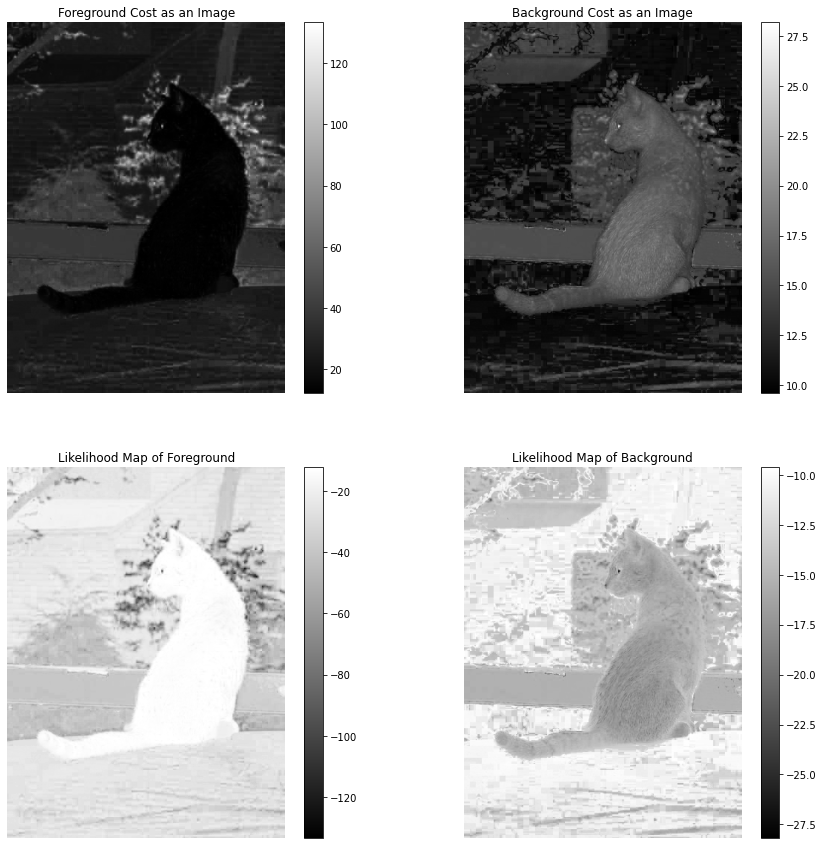

In [15]:
# 3. Compute and visualize the foreground cost and background cost as an image.
# Foreground label cost: -log Pr[Image | foreground model]
# Foreground label cost: -log Pr[Image | background model]
cost_fg = -gmm_fg.score_samples(img.reshape(-1, 3))
cost_fg = cost_fg.reshape(img.shape[:2])

cost_bg = -gmm_bg.score_samples(img.reshape(-1, 3))
cost_bg = cost_bg.reshape(img.shape[:2])

gmm_bg_likelihood_map,gmm_fg_likelihood_map = visualize_likelihood_map(gmm_bg, gmm_fg, img)

plt.figure(figsize=(15,15))
plt.subplot(2, 2, 1)
plt.imshow(cost_fg)
plt.axis('off')
plt.colorbar()
plt.title("Foreground Cost as an Image")

plt.subplot(2, 2, 2)
plt.imshow(cost_bg)
plt.axis('off')
plt.colorbar()
plt.title("Background Cost as an Image")

plt.subplot(2, 2, 3)
plt.imshow(gmm_fg_likelihood_map)
plt.axis('off')
plt.colorbar()
plt.title("Likelihood Map of Foreground")

plt.subplot(2, 2, 4)
plt.imshow(gmm_bg_likelihood_map)
plt.axis('off')
plt.colorbar()
plt.title("Likelihood Map of Background")
plt.show()

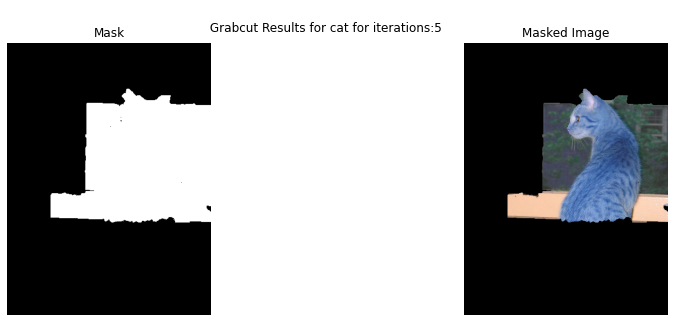

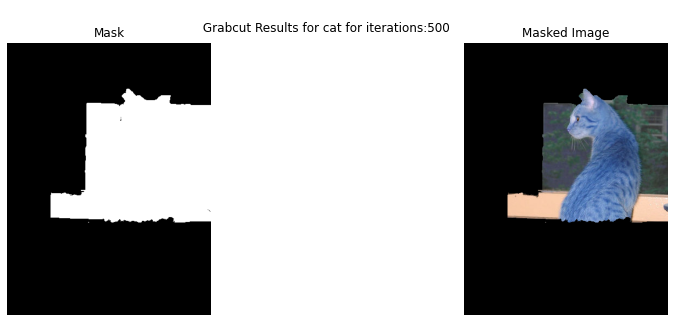

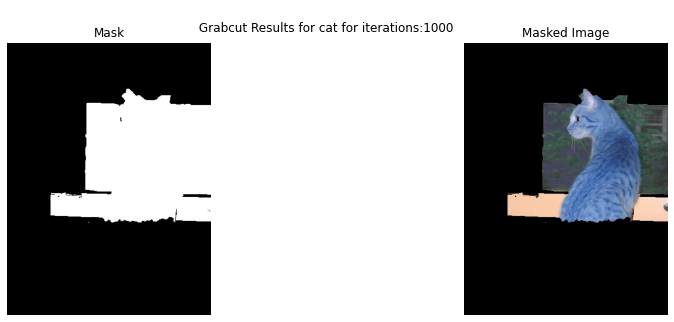

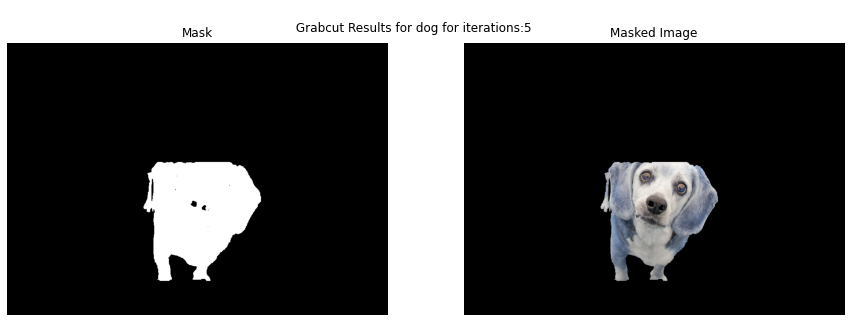

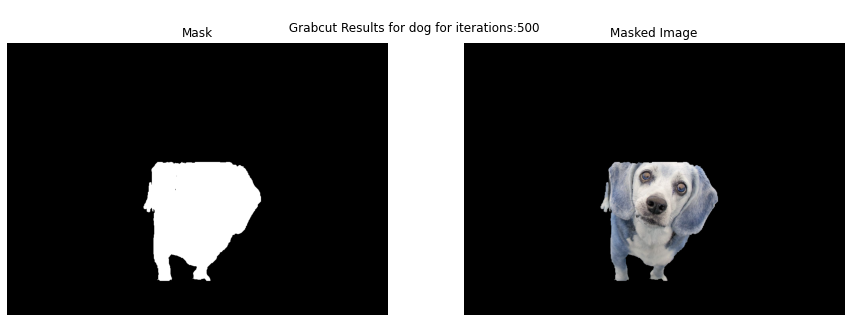

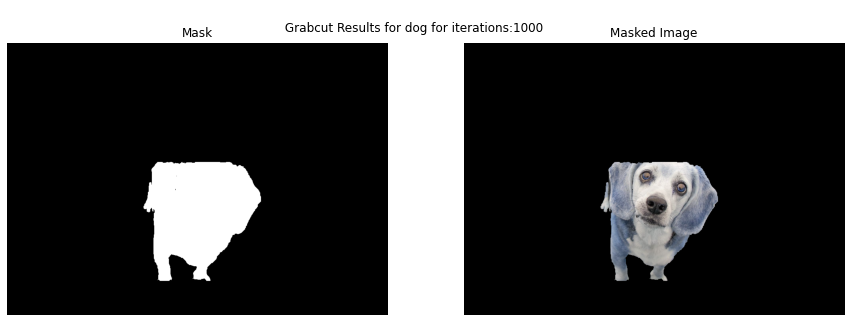

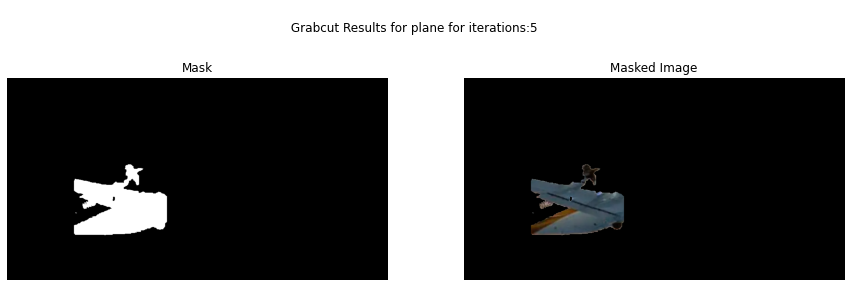

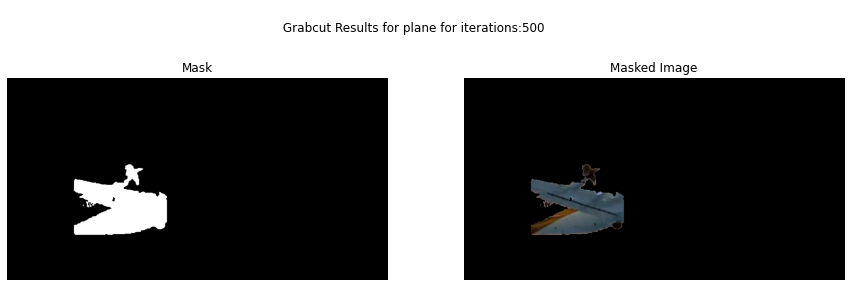

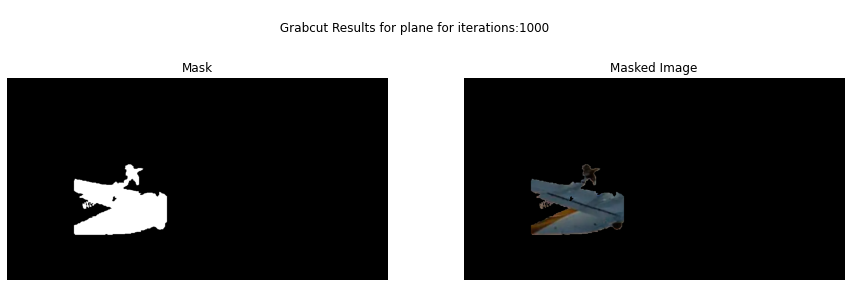

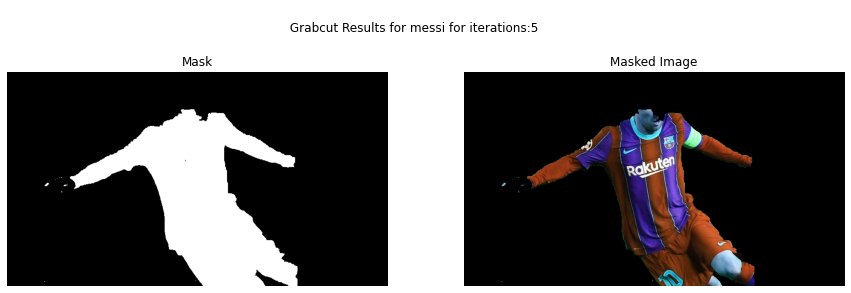

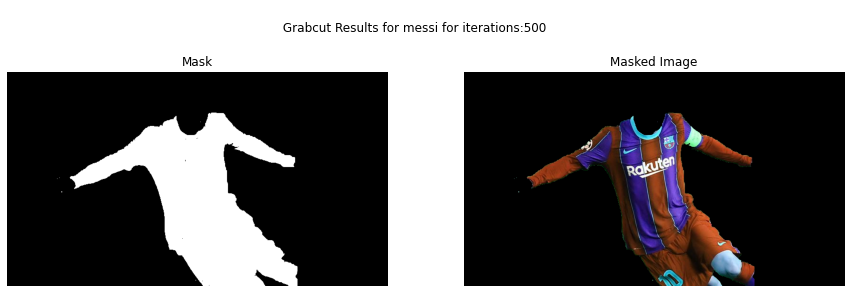

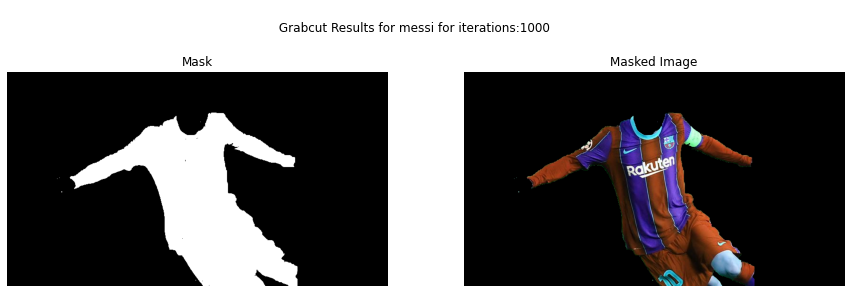

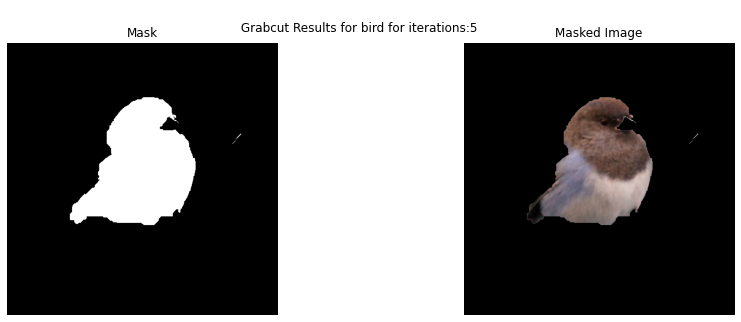

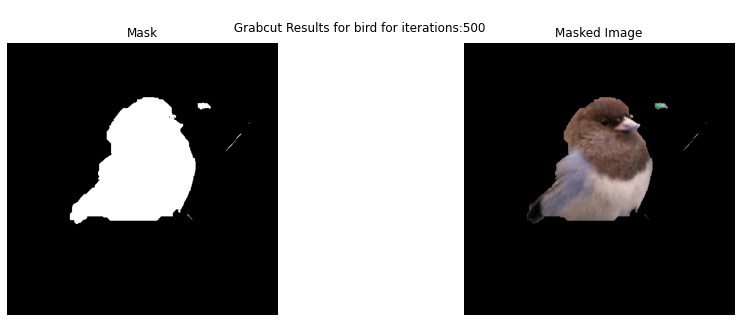

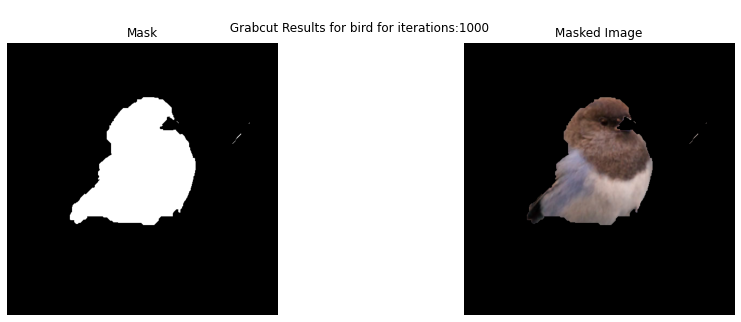

In [16]:
# 4. Run grabcut algorithm.
bboxes = {'cat':(80,80,320,250), 'dog':(50,300,600,300), 'plane': (180,80,250,800), 'messi':(10,80,600,500), 'bird':(100,100,350,250)}

for img_name,iterCount in itertools.product(bboxes,(5,500,1000)):
  img = cv2.imread(f'/content/Part2_GraphCut/{img_name}.jpg')
  bbox = bboxes[img_name]
  grabcut_mask, bgModel, fgModel = run_grabcut(img, bbox, iterCount)
  grabcut_mask = np.where((grabcut_mask==2)|(grabcut_mask==0),0,1).astype('uint8')
  masked_img = img*grabcut_mask[:,:,np.newaxis]

  fig, ax = plt.subplots(1,2,figsize=(15,5))
  fig.suptitle(f'\n Grabcut Results for {img_name} for iterations:{iterCount}')
  im0 = ax[0].imshow(grabcut_mask, cmap='gray')
  ax[0].set_title('Mask')
  ax[0].axis('off')

  im1 = ax[1].imshow(masked_img)
  ax[1].set_title('Masked Image')
  ax[1].axis('off')
  plt.show()

### Write-up (35 points)

- a) [5 points] Explain your foreground and background likelihood function.
- b) [10 points] Your foreground and background likelihood map. 

Display P(foreground|pixel)P(foreground|pixel) as an intensity map (bright = confident foreground).
- c) [15 points] Implement grabcut segmentation using cv2 package and draw insights on how the segmentation performs on different sample images (hard v/s easy). different colors in bg and fg, edge weights 
- d) [5 points] Try grabcut algorithm with different "iterCount" to see if results improve in certain cases. 

###**Writeup**
###A.
The foreground and background model computed from the Gaussian Mixture Model function are given as inputs to the visualize likelihood function which returns the likelihood of the data under the given model. The foreground and background scores are computed by taking the log probability of the model in the image and return the posterior distribution of each mixture component for each element of the model.

###C. & D.
From the obtained results, it can be inferred that   
1. For dog input image, at iterations at 5,500,1000 the output masked images are similar to eachother as the edge weights of the segemented image(dog) can be easily distinguished and can be labelled whether it is forground(source) or background(sink). Threfore, the grabcut function easily segments the image in less number of iterations.
2. While in case of messi, at iteration equal to 5 it can be seen that the result of the segmented image shows part of messi's face while also removes his hand as the algorithm cannot eaily distinguish the edge weights if they belong to foreground or background. When the number of iterations are increased,i,e, at iteration equal to 1000, it can be seen that the messi's head is segmented correctly as it is now able to differentiate between foreground and background.Therefore, for completely masked image.


### Hints 
- You may refer to https://docs.opencv.org/4.x/dd/dfc/tutorial_js_grabcut.html to implement run_grabcut()